# Летний проект

## Тема: Анализ тональности текста
## Задача: Распознование эмоций автора сообщения

In [1]:
import tensorflow as tf
import tensorflow_datasets
import keras
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, Flatten, SimpleRNN, GRU, Conv2D, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint


 ## Используется датасет GoEmotions
 
 GoEmotions – это корпус из 58 тысяч размеченных комментариев из Reddit, с аннотацией из 27 категорий эмоций или нейтральные. 
*	Количество примеров: 58,009.
*	Количество категорий: 27 + нейтральная.
*	Максимальная длинна текста 30 символов.
*	Язык: английский.

Категории эмоций включают: _восхищение, веселье, гнев, раздражение, одобрение, забота, замешательство, любопытство, желание, разочарование, неодобрение, отвращение, смущение, волнение, страх, благодарность, горе, радость, любовь, нервозность, оптимизм, гордость, осознание, облегчение, раскаяние, печаль, удивление_.
 ### C помощью Google API его можно скачать следующими командами

In [ ]:
#Windows
#!pip install wget
!python -m wget https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv -o goemotions_1.csv
!python -m wget https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv -o goemotions_2.csv
!python -m wget https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv -o goemotions_3.csv

In [ ]:
#linux(Google Collab)
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv &> /dev/null
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv &> /dev/null
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv &> /dev/null

### Далее нужно обработать "сырые" данны, убрать лишние столбцы, привести их к виду пригодному для обучения

In [ ]:
df1 = pd.read_csv('/content/data/full_dataset/goemotions_1.csv')
df2 = pd.read_csv('/content/data/full_dataset/goemotions_2.csv')
df3 = pd.read_csv('/content/data/full_dataset/goemotions_3.csv')
df = pd.concat([df1, df2, df3], sort=False)

In [ ]:
df.drop(['id', 'link_id','parent_id','created_utc','rater_id','example_very_unclear'], axis=1, inplace=True)
df.drop_duplicates(subset=['text', 'author', 'subreddit'], inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
# проверка количества сообщений должно быть 58,009
len(df)

58009

In [ ]:
df_analysis = df[['text']]
emotions = df.drop(columns=['text','author','subreddit'], axis=1, inplace=False).idxmax(axis=1)
df_analysis.loc[:, 'text_emotion'] = emotions

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
df_analysis.describe()

,text,text_emotion
count,58009,58009
unique,57732,28
top,Thank you.,neutral
freq,15,15523


In [ ]:
comments =df_analysis['text']

## Предобработка текста
1. Перевод в нижний регистр
2. Нормализация ссылок, майла, чисел
3. Аннотация капса, протяжных слов, повторов, подчеркиваний, цензуры
4. Коррекция слов
5. Аннотация смайликов
6. Токенизация

In [6]:
#!pip install ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# Максимальное количество слов 
num_words = 10000
# Максимальная длина комментария
max_comment_len = 33

In [7]:
emoticons_additional = {
	'(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
	':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
	':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
    	'<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
      '<3':'<happy>','¯_(ツ)_/¯':'<why> ',
}

In [8]:
text_processor1 = TextPreProcessor(
	# terms that will be normalized
	normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
           	'time', 'url', 'date'],
	# terms that will be annotated
	annotate={"allcaps", "elongated", "repeated",
          	'emphasis', 'censored'},
	fix_html=True,  # fix HTML tokens
	# corpus from which the word statistics are going to be used
	# for word segmentation
	segmenter="twitter",
	# corpus from which the word statistics are going to be used
	# for spell correction
	corrector="twitter",
	unpack_hashtags=True,  # perform word segmentation on hashtags
	unpack_contractions=True,  # Unpack contractions (can't -> can not)
	spell_correct_elong=True,  # spell correction for elongated words
	# select a tokenizer. You can use SocialTokenizer, or pass your own
	# the tokenizer, should take as input a string and return a list of tokens
	tokenizer=SocialTokenizer(lowercase=True).tokenize,
	# list of dictionaries, for replacing tokens extracted from the text,
	# with other expressions. You can pass more than one dictionaries.
	dicts=[emoticons, emoticons_additional]
)
text_processor2 = TextPreProcessor(
    # terms that will be normalized
# terms that will be normalized
	normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
           	'time', 'url', 'date','number'],
	# terms that will be annotated
	annotate={"allcaps", "elongated", "repeated",
          	'emphasis', 'censored'},
	fix_html=True,  # fix HTML tokens
	# corpus from which the word statistics are going to be used
	# for word segmentation
	segmenter="twitter",
	# corpus from which the word statistics are going to be used
	# for spell correction
	corrector="twitter",
	unpack_hashtags=True,  # perform word segmentation on hashtags
	unpack_contractions=True,  # Unpack contractions (can't -> can not)
	spell_correct_elong=True,  # spell correction for elongated words
	# select a tokenizer. You can use SocialTokenizer, or pass your own
	# the tokenizer, should take as input a string and return a list of tokens
	tokenizer=SocialTokenizer(lowercase=True).tokenize,
	# list of dictionaries, for replacing tokens extracted from the text,
	# with other expressions. You can pass more than one dictionaries.
	dicts=[emoticons, emoticons_additional]
)

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [9]:
def tokenize(text):
    text1 = " ".join(text_processor1.pre_process_doc(text)) # двойной цикл предобработки так как регулярнве выражения сначала
    text2 = " ".join(text_processor2.pre_process_doc(text1)) # ищут цифры затем смайлы(важнейший отрибут задачи теряется)
    return text2

In [ ]:
texts = []
for s in comments:
  text = tokenize(s)
  texts.append(text)

KeyboardInterrupt: ignored

In [ ]:
texts[:20]

['that game hurt .',
 '> sexuality shouldn ’ t be a grouping category it makes you different from othet ppl so imo it fits the definition of " grouping "',
 "you do right , if you do not care then fuck ' em !",
 'man i love reddit .',
 '[ <allcaps> name </allcaps> ] was nowhere near them , he was by the falcon .',
 'right ? considering it ’ s such an important document , i should know the damned thing backwards and forwards . <repeated> thanks again for the help !',
 "he is not as big , but he ' s still quite popular . i have heard the same thing about his content . never watched him much .",
 "that ' s crazy ; i went to a super [ <allcaps> religion </allcaps> ] high school and i think i can remember <number> girls the entire <number> years that became teen moms .",
 "that ' s adorable asf",
 '" sponge blurb pubs quaw haha <allcaps> gurr </allcaps> ha i <elongated> ! " finale is too real',
 "i have , and now that you mention it , i think that ' s what triggered my nostalgia .",
 "i wan

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words, filters='{|}~[]<>\t\n')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x_train = pad_sequences(sequences, maxlen=max_comment_len)

In [ ]:
x_train

array([[   0,    0,    0, ...,  153,  527,    1],
       [   0,    0,    0, ...,   47, 7856,   47],
       [   0,    0,    0, ...,   21,  993,   18],
       ...,
       [   0,    0,    0, ...,    8,   15,    9],
       [   0,    0,    0, ...,   15,    9,    1],
       [   0,    0,    0, ...,   17,  224,    1]], dtype=int32)

In [ ]:
tokenizer.word_index

In [ ]:
y_train = pd.get_dummies(df_analysis['text_emotion'])
train_labels = df_analysis.text_emotion.values

## One Hot Encoding
Представление текста в виде вектора из единиц и нулей, где токены, присутсвующие в тексте обознааются единицей. 
Чтобы представить вектора в виде One Hot Encoding написана функция to_eho() (потребляет много ОЗУ так как это разряженные вектора)

In [ ]:
def to_eho(sequences,dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
X_train = to_eho(x_train,num_words)

In [ ]:
# деление на тренировоную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Полносвязная нейронная сеть

In [ ]:
def build_ohe_model(num_words):
    model_ohe = Sequential()
    model_ohe.add(Dense(200,activation='relu', input_shape=(num_words,)))
    model_ohe.add(Dropout(0.5))
    model_ohe.add(Dense( 150,activation='relu', input_shape=(num_words,)))
    model_ohe.add(Dropout(0.4))
    model_ohe.add(Dense(80,activation='relu', input_shape=(num_words,)))
    model_ohe.add(Dense(len(np.unique(train_labels)),activation='sigmoid'))
    
    model_ohe.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(),
                            tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),
                            tf.keras.metrics.FalseNegatives()])
    return model_ohe
model_ohe = build_ohe_model(num_words=num_words)

In [ ]:
model_ohe_save_path = 'best_model_ohe.h5'
checkpoint_callback_ohe = ModelCheckpoint(model_ohe_save_path,
                                            monitor="val_loss",
                                           save_best_only=True,
                                           verbose=1)

In [ ]:
model_ohe.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               6800      
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 150)               30150     
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_6 (Dense)             (None, 80)                12080     
                                                                 
 dense_7 (Dense)             (None, 28)                2268      
                                                                 
Total params: 51,298
Trainable params: 51,298
Non-trai

In [ ]:
history_ohe = model_ohe.fit(X_train, 
                              y_train, 
                              epochs=30,
                              batch_size=52,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_ohe])

NameError: ignored

#### Оценка результатов

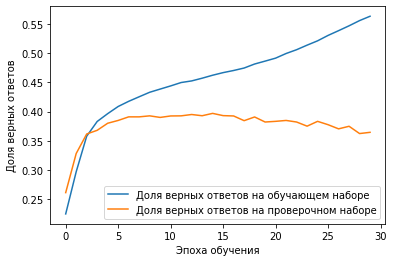

In [ ]:
plt.plot(history_ohe.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_ohe.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
best_model_ohe = keras.models.load_model('/content/best_model_ohe.h5')

In [ ]:
best_model_ohe.evaluate(X_test, y_test)

## Embedding
Это представление токенов в виде **массива вещественных чисел**

In [ ]:
# деление на тренировоную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
X_train

array([[   0,    0,    0, ...,   43,  221,  391],
       [   0,    0,    0, ...,   58,  335,    1],
       [   0,    0,    0, ...,    1,   14,    1],
       ...,
       [   0,    0,    0, ...,   42,    6,  436],
       [   0,    0,    0, ..., 2007, 1728,    1],
       [   0,    0,    0, ...,  323,  478,    1]], dtype=int32)

In [ ]:
y_train

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
7324,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23725,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39671,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57401,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38158,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15795,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Полносвязная нейронная сеть

In [ ]:
def build_dense_model(num_words, input_length):
  model_dense = Sequential()
  model_dense.add(Embedding(num_words, 28, input_length=input_length))
  model_dense.add(SpatialDropout1D(0.4))
  model_dense.add(Flatten())
  model_dense.add(Dense( 150,activation='relu', input_shape=(num_words,)))
  model_dense.add(Dropout(0.4))
  model_dense.add(Dense(80,activation='relu', input_shape=(num_words,)))
  model_dense.add(Dense(len(np.unique(train_labels)),activation='sigmoid'))
    
  model_dense.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(),
                        tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),
                        tf.keras.metrics.FalseNegatives()])
  return model_dense

model_dense = build_dense_model(num_words=num_words, input_length=max_comment_len)

In [ ]:
model_dense_save_path = 'best_model_dense.h5'
checkpoint_callback_dense = ModelCheckpoint(model_dense_save_path,
                                            monitor="val_loss",
                                           save_best_only=True,
                                           verbose=1)

In [ ]:
model_dense.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 33, 200)           2000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 33, 200)          0         
 lDropout1D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 6600)              0         
                                                                 
 dense_17 (Dense)            (None, 150)               990150    
                                                                 
 dropout_7 (Dropout)         (None, 150)               0         
                                                                 
 dense_18 (Dense)            (None, 80)                12080     
                                                      

In [ ]:
history_dense = model_dense.fit(X_train, 
                              y_train, 
                              epochs=15,
                              batch_size=52,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_dense])

Epoch 1/15
902/904 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.2555 - auc_1: 0.6569 - precision_1: 0.0898 - recall_1: 0.0503 - true_positives_1: 2358.0000 - true_negatives_1: 1242513.0000 - false_positives_1: 23895.0000 - false_negatives_1: 44546.0000
Epoch 1: val_loss improved from inf to 0.13529, saving model to best_model_dense.h5
904/904 [==============================] - 11s 10ms/step - loss: 0.2072 - accuracy: 0.2555 - auc_1: 0.6570 - precision_1: 0.0898 - recall_1: 0.0502 - true_positives_1: 2358.0000 - true_negatives_1: 1244754.0000 - false_positives_1: 23895.0000 - false_negatives_1: 44629.0000 - val_loss: 0.1353 - val_accuracy: 0.2614 - val_auc_1: 0.7582 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 140967.0000 - val_false_positives_1: 0.0000e+00 - val_false_negatives_1: 5221.0000
Epoch 2/15
902/904 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.2685 - au

#### Оценка результатов

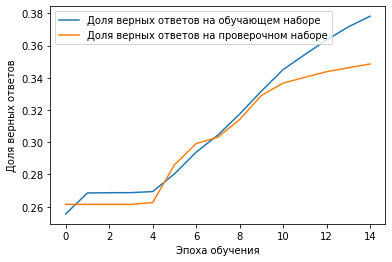

In [ ]:
plt.plot(history_dense.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_dense.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
best_model_dense = keras.models.load_model('/content/best_model_dense.h5')

In [ ]:
best_model_dense.evaluate(X_test, y_test)

182/182 [==============================] - 1s 2ms/step - loss: 0.1170 - accuracy: 0.3518 - auc_1: 0.8515 - precision_1: 0.5349 - recall_1: 0.1388 - true_positives_1: 805.0000 - true_negatives_1: 155927.0000 - false_positives_1: 700.0000 - false_negatives_1: 4996.0000


[0.11699564754962921,
 0.35183587670326233,
 0.8514639735221863,
 0.5348837375640869,
 0.13876917958259583,
 805.0,
 155927.0,
 700.0,
 4996.0]

##### Визуализация Эмбеддинга

In [ ]:
embedding_matrix = best_model_dense.layers[0].get_weights()[0]

Если на входном слое столько же нейронов сколько эмоций, то можно статистически посмотреть **с какими словами коррелируют эмоции**

In [ ]:
# 28 нейронов на входном слое
emotions = ['admiration', 'amusement', 'anger',	'annoyance',	'approval',	'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
              'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
              'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
word = ''
for i, arr in enumerate(embedding_matrix):
  for j, num in enumerate(arr):
    if num>=0.2 or num<=-0.2:
      for word,nnn in tokenizer.word_index.items():
        if nnn == i:
          word = word
          print('слово:{}   эмоция:{}   :{}'.format(word,emotions[j],num))

слово:?   эмоция:amusement   :-0.2734052240848541
слово:?   эмоция:confusion   :0.2591572701931
слово:?   эмоция:disapproval   :-0.239861398935318
слово:?   эмоция:excitement   :-0.20156581699848175
слово:?   эмоция:gratitude   :-0.2714092433452606
слово:?   эмоция:nervousness   :0.2159278392791748
слово:?   эмоция:realization   :0.2278323620557785
слово:?   эмоция:sadness   :-0.2650585174560547
слово:?   эмоция:surprise   :0.2160504013299942
слово:love   эмоция:amusement   :-0.2943704128265381
слово:love   эмоция:anger   :0.37575599551200867
слово:love   эмоция:annoyance   :0.36066296696662903
слово:love   эмоция:caring   :-0.30196884274482727
слово:love   эмоция:grief   :0.305808424949646
слово:love   эмоция:optimism   :-0.26195162534713745
слово:love   эмоция:realization   :0.26003846526145935
слово:love   эмоция:remorse   :-0.2640283405780792
слово:love   эмоция:neutral   :-0.2379489243030548
слово:thanks   эмоция:admiration   :0.26840871572494507
слово:thanks   эмоция:amusement   

In [ ]:
word = 'he'
word_number = tokenizer.word_index[word]
print('Номер слова', word_number)
print('Вектор для слова', embedding_matrix[word_number])

Номер слова 38
Вектор для слова [ 0.01507097  0.0156404  -0.01529608 -0.00331962 -0.05530879 -0.04155085
  0.02320545 -0.02032716 -0.01039243 -0.0267885  -0.04443806 -0.01253036
  0.06068004  0.02996479 -0.01125081  0.01740272  0.01549875  0.02378232
  0.0171436   0.02210606  0.00627015  0.00743633  0.0264587   0.03941128
 -0.01578449 -0.02603203 -0.00553014 -0.0171623 ]


Представление по эмоциям

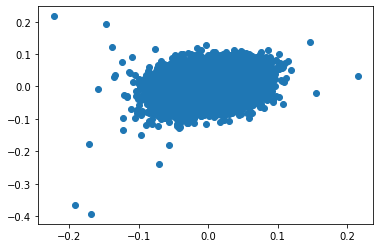

In [ ]:
plt.scatter(embedding_matrix[:,26], embedding_matrix[:,27])

In [ ]:
word_index = []
review = ['brilliant', 'fantastic', 'amazing', 'good',
          'bad', 'awful','crap', 'terrible', 'trash','norm','i','you']
enc_review = []
for word in review:
    enc_review.append(tokenizer.word_index[word])
review_vectors = embedding_matrix[enc_review]

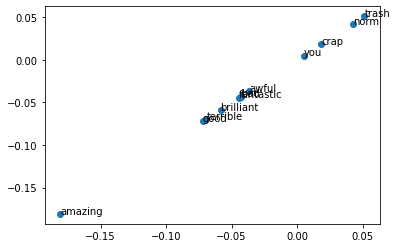

In [ ]:
plt.scatter(review_vectors[:,27], review_vectors[:,27])
for i, txt in enumerate(review):
    plt.annotate(txt, (review_vectors[i,27], review_vectors[i,27]))

Представление в целом

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(embedding_matrix)

X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



AttributeError: ignored

In [ ]:
emotions_label = []
for arr in embedding_matrix:
  emotions_label.append(emotions[arr.argmax()])

In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=emotions_label)
df_embeddings = df_embeddings.assign(text=list(tokenizer.word_index.items())[:num_words])

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    hover_data=['text'], title = 'GoEmotions Embedding Visualization')
fig.show()

### Рекуррентные нейронные сети
Функции принимают в виде последнего аргумента рекурректный слой: SimpleRNN, GRU или LSTM

In [ ]:
def build_rnn_model(num_words, input_length, keras_layer):
  model_rnn = Sequential()
  model_rnn.add(Embedding(num_words, 200, input_length=input_length))
  model_rnn.add(SpatialDropout1D(0.4))
  model_rnn.add(keras_layer(100, return_sequences=True))
  model_rnn.add(SpatialDropout1D(0.4))
  model_rnn.add(keras_layer(60))
  model_rnn.add(Dense(len(np.unique(train_labels)),activation='sigmoid'))
    
  model_rnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(),
                        tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),
                        tf.keras.metrics.FalseNegatives()])
  return model_rnn

def build_biderectional_rnn_model(num_words, input_length, keras_layer):
  model_rnn = Sequential()
  model_rnn.add(Embedding(num_words, 200, input_length=input_length))
  model_rnn.add(SpatialDropout1D(0.4))
  model_rnn.add(Bidirectional(keras_layer(100, return_sequences=True)))
  model_rnn.add(SpatialDropout1D(0.4))
  model_rnn.add(Bidirectional(keras_layer(60)))
  model_rnn.add(Dense(len(np.unique(train_labels)),activation='sigmoid'))
    
  model_rnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(),
                        tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),
                        tf.keras.metrics.FalseNegatives()])
  return model_rnn


In [ ]:
model_rnn = build_biderectional_rnn_model(num_words=num_words, input_length=max_comment_len, keras_layer=LSTM)

In [ ]:
model_rnn_save_path = 'best_model_rnn.h5'
checkpoint_callback_rnn= ModelCheckpoint(model_rnn_save_path,
                                            monitor="val_loss",
                                           save_best_only=True,
                                           verbose=1)

In [ ]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 200)           2000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 33, 200)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 33, 200)          240800    
 nal)                                                            
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 33, 200)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 120)              125280    
 nal)                                                 

In [ ]:
history_rnn = model_rnn.fit(X_train, 
                              y_train, 
                              epochs=15,
                              batch_size=52,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_rnn])

Epoch 1/15
904/904 [==============================] - ETA: 0s - loss: 0.1382 - accuracy: 0.2679 - auc_1: 0.7683 - precision_1: 0.0643 - recall_1: 0.0023 - true_positives_1: 108.0000 - true_negatives_1: 1267077.0000 - false_positives_1: 1572.0000 - false_negatives_1: 46879.0000
Epoch 1: val_loss improved from inf to 0.12729, saving model to best_model_rnn.h5
904/904 [==============================] - 179s 189ms/step - loss: 0.1382 - accuracy: 0.2679 - auc_1: 0.7683 - precision_1: 0.0643 - recall_1: 0.0023 - true_positives_1: 108.0000 - true_negatives_1: 1267077.0000 - false_positives_1: 1572.0000 - false_negatives_1: 46879.0000 - val_loss: 0.1273 - val_accuracy: 0.3043 - val_auc_1: 0.8063 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 140967.0000 - val_false_positives_1: 0.0000e+00 - val_false_negatives_1: 5221.0000
Epoch 2/15
904/904 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.3277 - auc_1:

#### Оценка результатов

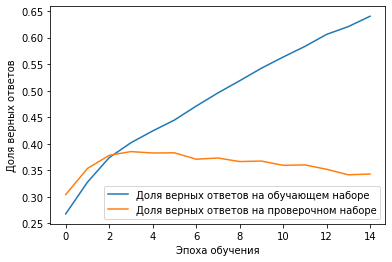

In [ ]:
plt.plot(history_rnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_rnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
best_model_rnn = keras.models.load_model('/content/best_model_rnn.h5')

In [ ]:
best_model_rnn.evaluate(X_test, y_test)

182/182 [==============================] - 8s 32ms/step - loss: 0.1090 - accuracy: 0.3858 - auc_1: 0.8814 - precision_1: 0.5603 - recall_1: 0.1738 - true_positives_1: 1008.0000 - true_negatives_1: 155836.0000 - false_positives_1: 791.0000 - false_negatives_1: 4793.0000


[0.10904113948345184,
 0.38579556345939636,
 0.8813761472702026,
 0.5603112578392029,
 0.17376314103603363,
 1008.0,
 155836.0,
 791.0,
 4793.0]

### Сверточная нейронная сеть

In [ ]:
def build_сnn_model(num_words, input_length):
  model_cnn = Sequential()
  model_cnn.add(Embedding(num_words, 200, input_length=input_length))
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Conv1D(64, 7, activation='relu', padding='same'))
  model_cnn.add(MaxPooling1D(2))
  model_cnn.add(Conv1D(64, 7, activation='relu', padding='same'))
  model_cnn.add(GlobalMaxPooling1D())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(len(np.unique(train_labels)),activation='sigmoid'))

    
  model_cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(),
                        tf.keras.metrics.TrueNegatives(),tf.keras.metrics.FalsePositives(),
                        tf.keras.metrics.FalseNegatives()])
  return model_cnn
model_cnn = build_сnn_model(num_words=num_words, input_length=max_comment_len)

In [ ]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn= ModelCheckpoint(model_cnn_save_path,
                                            monitor="val_loss",
                                           save_best_only=True,
                                           verbose=1)

In [ ]:
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 33, 200)           2000000   
                                                                 
 dropout_21 (Dropout)        (None, 33, 200)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 33, 64)            89664     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 16, 64)           0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 16, 64)            28736     
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                     

In [ ]:
history_cnn = model_cnn.fit(X_train, 
                              y_train, 
                              epochs=35,
                              batch_size=52,
                              validation_split=0.1,
                              callbacks=[checkpoint_callback_cnn])

Epoch 1/35
902/904 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.2346 - auc_9: 0.7000 - precision_9: 0.0685 - recall_9: 0.0184 - true_positives_9: 864.0000 - true_negatives_9: 1254667.0000 - false_positives_9: 11741.0000 - false_negatives_9: 46040.0000
Epoch 1: val_loss improved from inf to 0.12710, saving model to best_model_cnn.h5
904/904 [==============================] - 12s 10ms/step - loss: 0.1613 - accuracy: 0.2346 - auc_9: 0.7001 - precision_9: 0.0686 - recall_9: 0.0184 - true_positives_9: 865.0000 - true_negatives_9: 1256904.0000 - false_positives_9: 11745.0000 - false_negatives_9: 46122.0000 - val_loss: 0.1271 - val_accuracy: 0.3229 - val_auc_9: 0.8097 - val_precision_9: 0.6774 - val_recall_9: 0.0121 - val_true_positives_9: 63.0000 - val_true_negatives_9: 140937.0000 - val_false_positives_9: 30.0000 - val_false_negatives_9: 5158.0000
Epoch 2/35
901/904 [============================>.] - ETA: 0s - loss: 0.1274 - accuracy: 0.3405 - auc_9: 0.8025 - prec

#### Оценка результатов

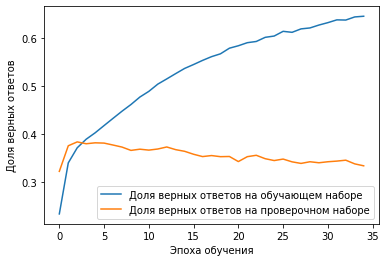

In [ ]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
best_model_cnn = keras.models.load_model('/content/best_model_cnn.h5')

In [ ]:
best_model_cnn.evaluate(X_test, y_test)

182/182 [==============================] - 2s 5ms/step - loss: 0.1115 - accuracy: 0.3813 - auc_9: 0.8718 - precision_9: 0.5894 - recall_9: 0.1364 - true_positives_9: 791.0000 - true_negatives_9: 156076.0000 - false_positives_9: 551.0000 - false_negatives_9: 5010.0000


[0.1115158423781395,
 0.3813135623931885,
 0.87181556224823,
 0.5894187688827515,
 0.13635580241680145,
 791.0,
 156076.0,
 551.0,
 5010.0]

## Bert
Используется "легкая" модель “bert_en_uncased_L-12_H-768_A-12“.

- L-12 : 12 скрытых слоев
- H-768 : 768 нейронов (размерность скрытого слоя)
- A-12 : 12 модулей внимания

In [3]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
!pip install bert-tensorflow &> /dev/null
!pip install sentencepiece &> /dev/null

In [ ]:
from bert import tokenization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.layers import Input
# The 4 next lines allows to prevent an error due to Bert version
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)
max_comment_len = 37
max_len = max_comment_len + 2

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
x = df_analysis.text.values

train_labels = df_analysis.text_emotion.values
y = pd.get_dummies(train_labels)

# деление на тренировоную и тестовую выборку
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1, random_state=42)
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)

In [ ]:
#!pip install emojis
import re
import emojis
texts = []
for s in comments:
  text = tokenize(s)
  text = re.sub('[/<>]', '', text)
  text = emojis.decode(text)
  texts.append(text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
prep_texts = texts
train_labels = df_analysis.text_emotion.values
y = pd.get_dummies(train_labels)

# деление на тренировоную и тестовую выборку
prep_X_train, prep_X_test, Y_train, Y_test = train_test_split(prep_texts, y, test_size=0.1, random_state=42)
prep_train_input = bert_encode(prep_X_train, tokenizer, max_len=max_len)
prep_test_input = bert_encode(prep_X_test, tokenizer, max_len=max_len)

In [ ]:
texts = prep_X_train[:10]
for text in texts:
  print(text)
  text = tokenizer.tokenize(text)
  print(text)      
  text = text[:max_len-2]
  print(text)
  input_sequence = ["[CLS]"] + text + ["[SEP]"]
  print(input_sequence)
  pad_len = max_len - len(input_sequence)
        
  tokens = tokenizer.convert_tokens_to_ids(input_sequence)
  print(tokens)
  tokens += [0] * pad_len
  print(tokens)
  pad_masks = [1] * len(input_sequence) + [0] * pad_len
  print(pad_masks)
  segment_ids = [0] * max_len
  print(segment_ids)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    flatten = Flatten(name='flatten')
    output_flatten = flatten(clf_output)

    out = Dense(len(np.unique(train_labels)), activation='sigmoid')(output_flatten)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=["accuracy",tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),
                            tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),
                            tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])
    
    return model

model = build_model(bert_layer, max_len=max_len)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 39)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 39)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 39)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 39, 768)]                 'input_mask[0][0]',      

In [ ]:
model_bert_save_path = 'best_model_bert.h5'
checkpoint_callback_bert = ModelCheckpoint(model_bert_save_path,
                                            monitor="val_loss",
                                           save_best_only=True,
                                           verbose=1)

In [ ]:
train_history = model.fit(
    prep_train_input, Y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=32,
    callbacks=[checkpoint_callback_bert]
)

Epoch 1/12
 276/1469 [====>.........................] - ETA: 4:14:06 - loss: 0.3329 - accuracy: 0.1174 - auc: 0.5883 - precision: 0.0441 - recall: 0.1213 - true_positives: 1071.0000 - true_negatives: 215253.0000 - false_positives: 23211.0000 - false_negatives: 7761.0000

#### Оценка результатов

In [ ]:
plt.plot(train_history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(train_history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [5]:
best_model_bert = keras.models.load_model('best_model_bert.h5',  custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
best_model_bert.evaluate(prep_test_input, Y_test)

##### Визуализация результатов

In [ ]:
intermediate_layer_model = Model(inputs=best_model_bert.input,
                                 outputs=best_model_bert.get_layer('flatten').output)
input = bert_encode(x, tokenizer, max_len=max_len)
sentence_embedded = intermediate_layer_model.predict(input)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(sentence_embedded)

X_embedded = TSNE(n_components=2).fit_transform(X)

In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=df_analysis.text_emotion.values)
df_embeddings = df_embeddings.assign(text=df_analysis.text.values)

In [ ]:
import plotly.express as px

fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', labels={'color': 'label'},
    hover_data=['text'], title = 'GoEmotions Embedding Visualization')
fig.show()